In [1]:
import pathlib

import yaml

import numpy as np

import itertools

In [ ]:
from pixell import enmap, utils as putils

In [ ]:
import utilities as u

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'cmss10'}
font = font_manager.FontProperties(family='Latin Modern Roman',
                                   style='normal', size = 8)


In [ ]:
import best
import re

In [71]:
values_file_regularised = 'configurations/configILCnonreg.yaml' 
with open(values_file_regularised, 'r') as stream:
            data = yaml.safe_load(stream)

In [72]:
values_file_regularised_largeLmax = 'configurations/configILCfilter.yaml' 
with open(values_file_regularised_largeLmax, 'r') as stream:
            data_reg_largeLmax = yaml.safe_load(stream)

In [73]:
values_file_non_regularised = 'configurations/configILCbiasesuncertainty.yaml' 
with open(values_file_non_regularised, 'r') as stream:
            data_nonreg = yaml.safe_load(stream)

In [74]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [75]:
nu

'ilc'

In [76]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [77]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [78]:
noisebiasconstr = False

In [79]:
results_directory_regularised = pathlib.Path(data['resultsdirectory'])
results_directory_regularised

PosixPath('resultssumfg_ILC_1503_non_reg')

In [80]:
results_directory_reg_largeLmax = pathlib.Path(data_reg_largeLmax['resultsdirectory'])
results_directory_reg_largeLmax

PosixPath('resultssumfg_ILC_2903_filtered')

In [81]:
results_directory_non_regularised = pathlib.Path(data_nonreg['resultsdirectory'])
results_directory_non_regularised

PosixPath('resultssumfg_ILC_2903_uncertaintybiases')

In [82]:
get_dir = lambda b, sybh, p, sy: f'b{b}sybh{sybh}p{p}sy{sy}'

In [83]:
lm = 3500
directory = get_dir(lm, lm, lm, lm)

In [84]:
w_reg = np.load(results_directory_regularised/directory/'w_auto_fb_1.0.npy')
w_reg_Lmax = np.load(results_directory_reg_largeLmax/directory/'w_auto_fb_1.0.npy')
w_non_reg = np.load(results_directory_non_regularised/directory/'w_auto_fb_1.0.npy')

In [85]:
biases_Lmax = np.load(results_directory_reg_largeLmax/directory/'biases.npy')

In [86]:
w_reg_Lmax[0]

array([ 45.74911884,  70.18497695, 107.67269654, 165.18363449,
       253.41274046, 388.76742983, 596.41876813, 914.98237683])

In [87]:
l = 3500
kk = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l)/'kk_ilc.npy')
theta = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l)/'theta_ilc.npy')
ells = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l)/'ells_ilc.npy')
selection = (ells > 30) & (ells < 1200)

In [88]:
ells

array([  12.67063702,   19.43837149,   29.82093841,   45.74911884,
         70.18497695,  107.67269654,  165.18363449,  253.41274046,
        388.76742983,  596.41876813,  914.98237683, 1403.69953905,
       2153.45393072, 3303.67268974])

In [89]:
for i, est in enumerate(colors_ests):
    print(est)
    print(abs(biases_Lmax[i, i]/kk[selection])<0.001)

bh
[False False False False False  True False False]
symmbh
[False False False False False False False False]
pbh
[False False False False False False False False]
symm
[False False False False False False False False]


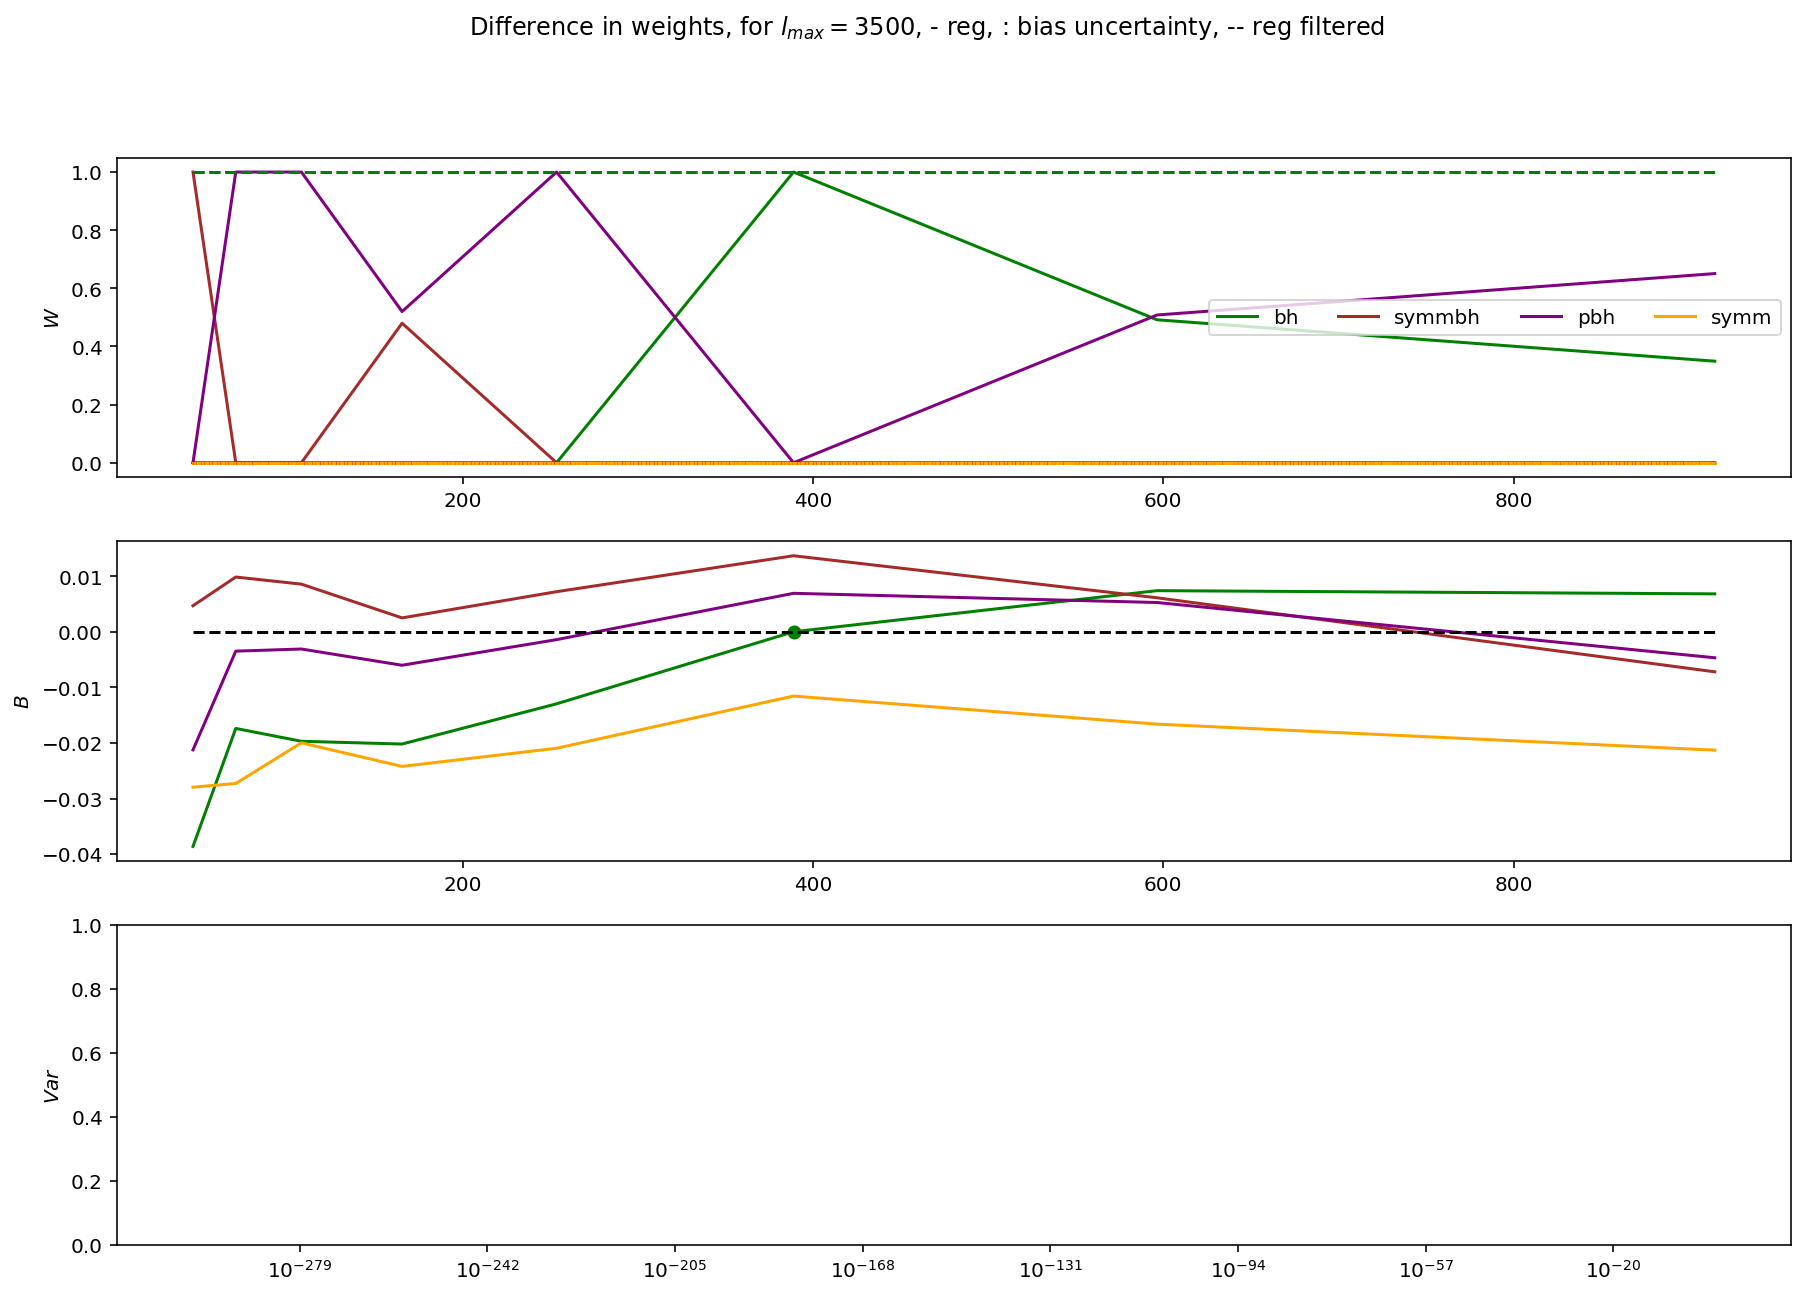

In [90]:
fig, ax = plt.subplots(nrows = 3, figsize = (15, 10))
fig.suptitle('Difference in weights, for $l_{max}=$'+f'{lm}, - reg, : bias uncertainty, -- reg filtered')


for i, est in enumerate(colors_ests):
    ax[0].plot(w_reg[0], w_reg[i+1], color = colors_ests[est], label = est)
for i, est in enumerate(colors_ests):
    ax[0].plot(w_reg_Lmax[0], w_reg_Lmax[i+1], color = colors_ests[est], ls = '--')
for i, est in enumerate(colors_ests):
    ax[0].plot(w_non_reg[0], w_non_reg[i+1], color = colors_ests[est], ls = ':')
    
for i, est in enumerate(colors_ests):
    ax[1].plot(w_reg_Lmax[0], biases_Lmax[i, i]/kk[selection], color = colors_ests[est])
    cases = abs(biases_Lmax[i, i]/kk[selection])<0.001
    ax[1].plot(w_reg_Lmax[0][cases], (biases_Lmax[i, i]/kk[selection])[cases], color = colors_ests[est], marker = 'o')
    
ax[1].plot(w_reg_Lmax[0], w_reg_Lmax[0]*0., ls = '--', color = 'black')
    
ax[0].legend(loc = 'best', ncol = len(colors_ests))

ax[0].set_ylabel('$W$')
ax[1].set_ylabel('$B$')
ax[2].set_ylabel('$Var$')

ax[-1].set_xscale('log')

In [91]:
all_results_dir = [results_directory_regularised, results_directory_reg_largeLmax, results_directory_non_regularised]

In [92]:
path = pathlib.Path(results_directory_regularised)
l = 3500
all_lmaxes_directories_reg =  [x.name for x in path.iterdir() if x.is_dir() and len(x.name)==len(get_dir(l, l, l, l))]

In [93]:
path = pathlib.Path(results_directory_reg_largeLmax)
l = 3500
all_lmaxes_directories_reg_Lmax =  [x.name for x in path.iterdir() if x.is_dir() and len(x.name)==len(get_dir(l, l, l, l))]

In [94]:
path = pathlib.Path(results_directory_non_regularised)
l = 3500
all_lmaxes_directories_nonreg =  [x.name for x in path.iterdir() if x.is_dir() and len(x.name)==len(get_dir(l, l, l, l))]

In [95]:
all_lmaxes_directories = set(all_lmaxes_directories_reg).intersection(set(all_lmaxes_directories_reg_Lmax))
all_lmaxes_directories = all_lmaxes_directories.intersection(set(all_lmaxes_directories_nonreg))
all_lmaxes_directories = list(all_lmaxes_directories)

In [96]:
len(all_lmaxes_directories)

256

In [97]:
def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

In [98]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)

In [99]:
fb = 1.
invvariance = False

In [100]:
reference_directory = pathlib.Path(analysis_directory)/'h3000s3000b3000p3000sy3000sybh3000/total/'

kk = np.load(reference_directory/'kk_total_ilc.npy')
theta = np.load(reference_directory/'theta_total_ilc.npy')
ells = np.load(reference_directory/'ells_total_ilc.npy')
selection = (ells > 30) & (ells < 1200)
biases = np.load(reference_directory/'totalbias_total_ilc.npy')
noises = np.load(reference_directory/'N_total_ilc.npy')
estimators_reference = ['h', 's', 'b', 'p', 'sy', 'sybh']
Optimizerkk = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
x_estimator = get_est_weights(Optimizerkk, index = 0)
f, n, b = fnb_getter(Optimizerkk, fb, True)
f_ref, n_ref, b_ref = f(x_estimator), n(x_estimator), b(x_estimator)

In [101]:
all_ref = [f_ref, n_ref, b_ref]
all_ref

[0.00012393890099688878, 0.007748854051847861, -0.007993382380447576]

In [102]:
all_results_dir

[PosixPath('resultssumfg_ILC_1503_non_reg'),
 PosixPath('resultssumfg_ILC_2903_filtered'),
 PosixPath('resultssumfg_ILC_2903_uncertaintybiases')]

In [103]:
def get_info(directory, resultspath):
    kk = np.load(pathlib.Path(analysis_directory)/directory/'kk_ilc.npy')
    theta = np.load(pathlib.Path(analysis_directory)/directory/'theta_ilc.npy')
    ells = np.load(pathlib.Path(analysis_directory)/directory/'ells_ilc.npy')
    selection = (ells > 30) & (ells < 1200)
    biases = np.load(pathlib.Path(analysis_directory)/directory/'total/totalbias_total_ilc.npy')
    noises = np.load(pathlib.Path(analysis_directory)/directory/'total/N_total_ilc.npy')
    w = np.load(resultspath/directory/'w_auto_fb_1.0.npy')
    x = np.load(resultspath/directory/'x_auto_fb_1.0.npy')
    return kk, theta, ells, biases, noises, w, x

In [104]:
all_lmaxes_directories[0]

'b3500sybh4000p4000sy3500'

In [105]:
#results_array = np.array([f_estimator, n_estimator, b_estimator])

In [106]:
def get_reg(Opt, biases, theorykk, threshold = 0.001):
    relative = biases/theorykk
    Ne = biases.shape[0]
    def reg(x):
        x = np.array(x)
        a = Opt.get_a(x, False).T
        total = 0.
        for i in range(Ne):
            selection = abs(relative[i, i]) < threshold
            total += np.sum(a[i]**2*selection)#*np.sum((1-(~selection)*a[i])**2.)
            print(selection)
        return total
    return reg

In [107]:
estimators

['bh', 'symmbh', 'pbh', 'symm']

In [108]:
kk, theta, ells, biases, noises, w, x = get_info('b4500sybh4500p3500sy3500', all_results_dir[0])

kk, theta, ells, biases, noises, w, x = get_info('b4000sybh3500p3500sy4500', all_results_dir[0])

Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
ggreg = get_reg(Optimizerkk, Optimizerkk.biases_selected, Optimizerkk.theory_selected)
print(ggreg(x))

a = np.c_[w[1:5]].T
wl = w[-1]
Optimizerkk_abs = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
a = np.c_[w[1:5]].T
wl = w[-1]
f, n, b = fnb_getter(Optimizerkk_abs, fb, invvariance)
fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)
print('Non reg abs', fcomb_abs)
f, n, b = fnb_getter(Optimizerkk, fb, invvariance)
fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)
print('Non reg', fcomb_abs)
aa = a.copy()
aa[5][2] = 1.
aa[5][0] = 0.
aa[5][1] = 0.
aa[5][3] = 0.
xx = np.append(aa.flatten(), wl)
ffcomb_abs = f(xx)
print(ffcomb_abs, '\n')


kk, theta, ells, biases, noises, w, x = get_info('b4000sybh3500p3500sy4500', all_results_dir[2])
a = np.c_[w[1:5]].T
wl = w[-1]
f, n, b = fnb_getter(Optimizerkk_abs, fb, invvariance)
fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)
print('Non reg abs', fcomb_abs)
f, n, b = fnb_getter(Optimizerkk, fb, invvariance)
fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)
print('Non reg', fcomb_abs)
aa = a.copy()
aa[5][2] = 1.
aa[5][0] = 0.
aa[5][1] = 0.
aa[5][3] = 0.
xx = np.append(aa.flatten(), wl)
ffcomb_abs = f(xx)
print(ffcomb_abs)

[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
0.0
Non reg abs 7.321745984705842e-05
Non reg 6.18098727719505e-05
6.534943772054102e-05 

Non reg abs 8.826381601172135e-05
Non reg 7.38048655745369e-05
7.38134678077828e-05


In [109]:
aa.shape

(8, 4)

In [110]:
def do_all(directory, results):
    print(f'From {results}')
    kk, theta, ells, biases, noises, w, x = get_info(directory, results)

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    
    Nestimators = len(Optimizerkk.estimators)
    Ne = Nestimators
    results_array = np.zeros((3, Nestimators+1))
    for index in range(Nestimators):
        x_estimator = get_est_weights(Optimizerkk, index = index)
        a_estimate = Optimizerkk.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)
        results_array[:, index+1] = np.array([f_estimator, n_estimator, b_estimator])

    a = np.c_[w[1:5]].T
    wl = w[-1]
    combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
    combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)

    combinedtheta = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)

    Optimizerkk_abs = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    f, n, b = fnb_getter(Optimizerkk_abs, fb, invvariance)
    fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)
   
    
    combinedb_abs = Optimizerkk_abs.get_bias_part(a, Optimizerkk_abs.biases_selected)
    combinedb_abs = combinedb_abs*bcomb_abs/Optimizerkk_abs.theory_selected


    ells = Optimizerkk.ells_selected
    kk = Optimizerkk.theory_selected
    Ne = len(Optimizerkk.estimators)


    names = ['BH', 'SYBH', 'PBH', 'SY']
    colors = ['green', 'brown', 'purple', 'orange']

    height_ratios = [1, 1, 3, 1, 1, 1]
    fig, ax = plt.subplots(nrows = 6, sharex = True, figsize = (15, 10), gridspec_kw = {'height_ratios': height_ratios})
    fig.suptitle(f'Case of fb = {fb}, best directory {directory}')
    ax[0].plot(ells, combinedb/kk, color = 'black', label = 'Combined', marker = 'o')

    for i in range(Ne):
        ax[0].plot(ells, Optimizerkk.biases_selected[i, i]/kk, color = colors[i], label = names[i])
        print(abs(Optimizerkk.biases_selected[i, i]/kk)<0.001)
    ax[0].plot(ells, ells*0, color = 'black', ls = '--')
    ax[0].legend(loc = 'best', ncol = len(names)+1)


    for i in range(Ne):
        ax[1].plot(ells, (Optimizerkk.theta_selected[i, i, i, i]/kk**2)**-1., color = colors[i])

    ax[1].plot(ells, (combinedtheta/kk**2)**-1., color = 'black', marker = 'o')
    ax[1].plot(ells, ells*0, color = 'black', ls = '--')

    #ax[2].plot(ells, wl**2*(combinedtheta/kk**2), color = 'black', ls = ':', label = 'Combined variance contr per L')
    #ax[2].plot(ells, wl*combinedb_abs, color = 'black', ls = '-.', label = 'Combined bias contr per L')
    
    
    listatemp = []
    for index in range(Ne):
        x_estimator = get_est_weights(Optimizerkk_abs, index = index)
        a_estimate = Optimizerkk_abs.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk_abs, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)

        combinedn_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.noises_selected)
        combinedb_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.biases_selected)
        b_example = b_estimator

        combinedb_abs_example = combinedb_example*b_example/Optimizerkk_abs.theory_selected

        variance = True
        theta_example = Optimizerkk_abs.theta_selected[index, index, index, index]
        wl_example = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, variance)

        print(f'Example is for {Optimizerkk.estimators[index]}')

        #ax[2].plot(ells, wl_example**2*(theta_example/kk**2), color = colors[index], ls = ':')
        #ax[2].plot(ells, wl_example*combinedb_abs_example, color = colors[index], ls = '-.')
        ax[2].plot(ells, wl_example**2*(theta_example/kk**2)+wl_example*combinedb_abs_example, color = colors[index], ls = ':')
        listatemp += [wl_example**2*(theta_example/kk**2)+wl_example*combinedb_abs_example]
    print(np.array(listatemp).shape)
    inv = np.array(listatemp)**-1.
    print(np.array(listatemp)/np.sum(np.array(listatemp), axis = 0))
    print(inv/np.sum(np.array(inv), axis = 0))
    
    ax[2].plot(ells, wl**2*(combinedtheta/kk**2)+wl*combinedb_abs)
        
        
    ax[2].plot(ells, ells*0, color = 'black', ls = '--')
    ax[2].legend(loc = 'best', ncol = 2)

    ax[3].plot(ells, ells*0, color = 'black', ls = '--')
    ax[5].plot(ells, ells*0, color = 'black', ls = '--')
    for i in range(Ne):
        ax[3].plot(ells, w[1+i], color = colors[i])
        ax[5].plot(ells, w[1+i]*wl*ells, color = colors[i])

    ax[4].plot(ells, wl, color = 'black')
    ax[4].plot(ells, ells*0., color = 'black', ls = '--')

    ax[0].set_ylabel('$\\frac{B}{C_L}$', size = 15)
    ax[1].set_ylabel('$(\\frac{\sigma^2}{C_L^2})^{-1}$', size = 15)
    ax[2].set_ylabel('$W_L\\mathrm{comb}$', size = 15)
    ax[3].set_ylabel('$W$', size = 15)
    ax[4].set_ylabel('$W_L$', size = 15)
    ax[-1].set_ylabel('$LW_LW$', size = 15)

    ax[0].set_xscale('log')
    ax[-1].set_xlabel('$L$')
    
    return 

In [111]:
import pandas

In [112]:
names

{'bh': 'b', 'symmbh': 'sybh', 'pbh': 'p', 'symm': 'sy'}

In [113]:
all_results_dir

[PosixPath('resultssumfg_ILC_1503_non_reg'),
 PosixPath('resultssumfg_ILC_2903_filtered'),
 PosixPath('resultssumfg_ILC_2903_uncertaintybiases')]

In [114]:
#results_array = np.array([f_estimator, n_estimator, b_estimator])

In [115]:
def make_table(resultsdir, all_lmaxes_directories, names, all_ref, autoname = 'Auto', include_estimators = True, include_dirs = True, include_ref = False):
    data = {}
    if include_dirs:
        data['Name'] = all_lmaxes_directories
    superarray = np.zeros((3, 1+len(names), len(all_lmaxes_directories)))
    for i, direc in enumerate(all_lmaxes_directories):
        results_array = np.load(resultsdir/direc/'alens.npy')
        superarray[:, :, i] = results_array
        
    data[f'Total {autoname}'] = superarray[0, 0]
    data[f'Noise {autoname}'] = superarray[1, 0]
    data[f'Bias {autoname}'] = superarray[2, 0]
    
    if include_ref:
        data[f'Noise {autoname} rtr'] = superarray[1, 0]/all_ref[1]
        data[f'Bias {autoname} rtr'] = superarray[2, 0]/all_ref[2]
        
    if include_estimators:
        for i, n in enumerate(names):
            #data[f'Total {n} rtr'] = superarray[0, i]/all_ref[0]
            data[f'Noise {n} rtr'] = superarray[1, i]/all_ref[1]
            data[f'Bias {n} rtr'] = superarray[2, i]/all_ref[2]
    
    return pandas.DataFrame(data)

In [116]:
all_results_dir

[PosixPath('resultssumfg_ILC_1503_non_reg'),
 PosixPath('resultssumfg_ILC_2903_filtered'),
 PosixPath('resultssumfg_ILC_2903_uncertaintybiases')]

In [140]:
dd_reg_all = make_table(all_results_dir[0], all_lmaxes_directories, names, all_ref, autoname = 'Auto reg', include_estimators = True, include_ref = True)

dd_reg = make_table(all_results_dir[0], all_lmaxes_directories, names, all_ref, autoname = 'Auto reg', include_estimators = False)
dd_non_reg = make_table(all_results_dir[2], all_lmaxes_directories, names, all_ref, autoname = 'Auto smoothed', include_estimators = False, include_dirs = False)
dd_reg_Large_Lmax = make_table(all_results_dir[1], all_lmaxes_directories, names, all_ref, autoname = 'Auto uncertain biases', include_estimators = False, include_dirs = False)

dd_reg_Large_Lmax_ = make_table(all_results_dir[1], all_lmaxes_directories, names, all_ref, autoname = 'Auto uncertain biases', include_estimators = False, include_dirs = False, include_ref = True)


#dd['e'] = dd['Noise Auto']**2+dd['Bias Auto']**2

In [118]:
dd_reg_all.sort_values(by = 'Total Auto reg').head(10)

,Name,Total Auto reg,Noise Auto reg,Bias Auto reg,Noise Auto reg rtr,Bias Auto reg rtr,Noise bh rtr,Bias bh rtr,Noise symmbh rtr,Bias symmbh rtr,Noise pbh rtr,Bias pbh rtr,Noise symm rtr,Bias symm rtr
130,b3500sybh3500p4000sy3500,0.000060,0.007688,0.000692,0.992191,-0.086537,0.992191,-0.086537,0.979612,1.076091,1.224807,-0.875619,0.970402,-1.200006
66,b3500sybh4500p4000sy4500,0.000060,0.007696,0.000626,0.993221,-0.078325,0.993221,-0.078325,0.979612,1.076091,1.136807,-1.934746,0.970402,-1.200006
151,b3500sybh3500p4000sy4500,0.000060,0.007726,0.000183,0.996995,-0.022886,0.996995,-0.022886,0.979612,1.076091,1.224807,-0.875619,0.970402,-1.200006
242,b3500sybh4500p4000sy4000,0.000060,0.007751,0.000007,1.000294,-0.000899,1.000294,-0.000899,0.979612,1.076091,1.136807,-1.934746,0.970402,-1.200006
45,b3500sybh4500p4000sy3500,0.000060,0.007754,0.000492,1.000724,-0.061606,1.000724,-0.061606,0.979612,1.076091,1.136807,-1.934746,0.970402,-1.200006
215,b3500sybh3500p4000sy4000,0.000060,0.007768,0.000331,1.002410,-0.041363,1.002410,-0.041363,0.979612,1.076091,1.224807,-0.875619,0.970402,-1.200006
123,b4500sybh4500p3500sy3500,0.000060,0.007762,-0.000450,1.001656,0.056249,1.001656,0.056249,0.895702,-1.494588,1.136807,-1.934746,1.031407,0.051557
48,b4000sybh4000p3500sy3000,0.000061,0.007799,0.000493,1.006467,-0.061662,1.006467,-0.061662,0.922405,-0.004582,1.165713,-1.225681,1.031407,0.051557
245,b4000sybh4000p3500sy3500,0.000061,0.007799,0.000492,1.006492,-0.061581,1.006492,-0.061581,0.922405,-0.004582,1.165713,-1.225681,1.031407,0.051557
118,b3500sybh4000p4000sy4000,0.000061,0.007804,0.000512,1.007084,-0.064014,1.007084,-0.064014,0.979612,1.076091,1.165713,-1.225681,0.970402,-1.200006


In [119]:
conc = pandas.concat([dd_reg, dd_non_reg, dd_reg_Large_Lmax], axis = 1)
conc

,Name,Total Auto reg,Noise Auto reg,Bias Auto reg,Total Auto smoothed,Noise Auto smoothed,Bias Auto smoothed,Total Auto uncertain biases,Noise Auto uncertain biases,Bias Auto uncertain biases
0,b3500sybh4000p4000sy3500,0.000068,0.008224,-0.000274,0.002307,0.032177,-0.035663,0.002307,0.032177,-0.035663
1,b4500sybh3500p3000sy3500,0.000087,0.009119,-0.001924,0.000102,0.008966,-0.004668,0.000133,0.010377,-0.005046
2,b3000sybh3500p3500sy3500,0.000065,0.008086,-0.000178,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169
3,b3000sybh4000p3000sy3500,0.000076,0.008717,0.000108,0.000180,0.009526,-0.009446,0.000184,0.009594,-0.009604
4,b3000sybh3000p3000sy3500,0.000091,0.009448,-0.001470,0.002458,0.020183,-0.045288,0.002458,0.020183,-0.045288
...,...,...,...,...,...,...,...,...,...,...
251,b3000sybh3500p4000sy4000,0.000071,0.008338,-0.001119,0.000088,0.008698,-0.003537,0.000077,0.008782,-0.000196
252,b3500sybh4500p4500sy4500,0.000072,0.008475,-0.000440,0.002981,0.028889,-0.046324,0.002981,0.028889,-0.046324
253,b3500sybh4000p3500sy4500,0.000062,0.007840,-0.000336,0.000095,0.009551,-0.002051,0.000099,0.009953,-0.000656
254,b4000sybh4500p3500sy4000,0.000062,0.007851,0.000217,0.006236,0.023272,-0.075461,0.006236,0.023272,-0.075461


In [120]:
conc.sort_values(by = 'Total Auto reg').head(10)

,Name,Total Auto reg,Noise Auto reg,Bias Auto reg,Total Auto smoothed,Noise Auto smoothed,Bias Auto smoothed,Total Auto uncertain biases,Noise Auto uncertain biases,Bias Auto uncertain biases
130,b3500sybh3500p4000sy3500,0.000060,0.007688,0.000692,0.000072,0.008304,-0.001799,0.000066,0.007944,0.001767
66,b3500sybh4500p4000sy4500,0.000060,0.007696,0.000626,0.004009,0.025511,-0.057948,0.004009,0.025511,-0.057948
151,b3500sybh3500p4000sy4500,0.000060,0.007726,0.000183,0.000069,0.008052,-0.001996,0.000064,0.007765,0.001943
242,b3500sybh4500p4000sy4000,0.000060,0.007751,0.000007,0.003860,0.027060,-0.055925,0.003860,0.027060,-0.055925
45,b3500sybh4500p4000sy3500,0.000060,0.007754,0.000492,0.002990,0.038590,-0.038746,0.002990,0.038590,-0.038746
215,b3500sybh3500p4000sy4000,0.000060,0.007768,0.000331,0.000061,0.007785,-0.000062,0.000066,0.007944,0.001768
123,b4500sybh4500p3500sy3500,0.000060,0.007762,-0.000450,0.003326,0.030129,-0.049177,0.003326,0.030129,-0.049177
48,b4000sybh4000p3500sy3000,0.000061,0.007799,0.000493,0.000135,0.010780,-0.004328,0.000135,0.010780,-0.004328
245,b4000sybh4000p3500sy3500,0.000061,0.007799,0.000492,0.006770,0.030057,-0.076596,0.006770,0.030057,-0.076596
118,b3500sybh4000p4000sy4000,0.000061,0.007804,0.000512,0.000092,0.009178,-0.002833,0.000088,0.009112,0.002260


In [121]:
conc.sort_values(by = 'Total Auto smoothed').head(10)

,Name,Total Auto reg,Noise Auto reg,Bias Auto reg,Total Auto smoothed,Noise Auto smoothed,Bias Auto smoothed,Total Auto uncertain biases,Noise Auto uncertain biases,Bias Auto uncertain biases
108,b3500sybh4500p4000sy3000,0.000064,0.007974,0.000210,0.000059,0.007673,0.000543,0.000063,0.007722,0.001753
126,b3500sybh3000p4000sy4000,0.000087,0.008699,-0.003302,0.000060,0.007708,0.000483,0.000064,0.007765,0.001944
237,b3500sybh3000p4000sy4500,0.000073,0.008521,-0.000901,0.000060,0.007708,0.000483,0.000066,0.007944,0.001767
144,b3500sybh3000p4000sy3500,0.000073,0.008518,-0.000649,0.000060,0.007708,0.000483,0.000066,0.007944,0.001767
215,b3500sybh3500p4000sy4000,0.000060,0.007768,0.000331,0.000061,0.007785,-0.000062,0.000066,0.007944,0.001768
165,b3500sybh3500p4500sy4000,0.000065,0.008073,0.000064,0.000064,0.007756,0.001832,0.000073,0.007763,0.003538
182,b3500sybh3000p4500sy4000,0.000076,0.008636,-0.001203,0.000064,0.007756,0.001832,0.000074,0.007944,0.003374
104,b3500sybh3500p4500sy4500,0.000062,0.007666,0.001883,0.000064,0.008006,0.000032,0.000074,0.007944,0.003374
233,b3500sybh3000p4500sy4500,0.000069,0.007838,0.002786,0.000064,0.008006,0.000032,0.000081,0.008686,0.002341
222,b4000sybh3500p3500sy4000,0.000070,0.008285,-0.001195,0.000065,0.007854,-0.001756,0.000081,0.008912,-0.001268


In [122]:
conc.sort_values(by = 'Total Auto uncertain biases').head(10)

,Name,Total Auto reg,Noise Auto reg,Bias Auto reg,Total Auto smoothed,Noise Auto smoothed,Bias Auto smoothed,Total Auto uncertain biases,Noise Auto uncertain biases,Bias Auto uncertain biases
108,b3500sybh4500p4000sy3000,0.000064,0.007974,0.000210,0.000059,0.007673,0.000543,0.000063,0.007722,0.001753
126,b3500sybh3000p4000sy4000,0.000087,0.008699,-0.003302,0.000060,0.007708,0.000483,0.000064,0.007765,0.001944
151,b3500sybh3500p4000sy4500,0.000060,0.007726,0.000183,0.000069,0.008052,-0.001996,0.000064,0.007765,0.001943
111,b3000sybh4500p3500sy4000,0.000064,0.007967,-0.000259,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169
19,b3000sybh4000p3500sy4500,0.000065,0.008034,-0.000197,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169
2,b3000sybh3500p3500sy3500,0.000065,0.008086,-0.000178,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169
95,b3000sybh4000p3500sy4000,0.000066,0.008097,-0.000236,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169
184,b3000sybh4500p3500sy4500,0.000088,0.009406,0.000117,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169
79,b3000sybh3500p3500sy4000,0.000066,0.008146,-0.000267,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169
122,b3000sybh3500p3500sy4500,0.000067,0.008169,-0.000143,0.000066,0.008136,-0.000284,0.000065,0.008086,-0.000169


In [141]:
dd_reg_Large_Lmax_.sort_values(by = 'Total Auto uncertain biases').head(10)

,Total Auto uncertain biases,Noise Auto uncertain biases,Bias Auto uncertain biases,Noise Auto uncertain biases rtr,Bias Auto uncertain biases rtr
108,0.000063,0.007722,0.001753,0.996598,-0.219317
126,0.000064,0.007765,0.001944,1.002053,-0.243151
151,0.000064,0.007765,0.001943,1.002061,-0.243135
111,0.000065,0.008086,-0.000169,1.043570,0.021080
19,0.000065,0.008086,-0.000169,1.043570,0.021081
2,0.000065,0.008086,-0.000169,1.043570,0.021080
95,0.000065,0.008086,-0.000169,1.043570,0.021080
184,0.000065,0.008086,-0.000169,1.043570,0.021081
79,0.000065,0.008086,-0.000169,1.043570,0.021080
122,0.000065,0.008086,-0.000169,1.043570,0.021080


In [130]:
direc_of_choice = 'b3500sybh4500p4000sy3000'

In [131]:
conc[conc['Name'] == direc_of_choice]

,Name,Total Auto reg,Noise Auto reg,Bias Auto reg,Total Auto smoothed,Noise Auto smoothed,Bias Auto smoothed,Total Auto uncertain biases,Noise Auto uncertain biases,Bias Auto uncertain biases
108,b3500sybh4500p4000sy3000,0.000064,0.007974,0.00021,0.000059,0.007673,0.000543,0.000063,0.007722,0.001753


No handles with labels found to put in legend.


From resultssumfg_ILC_1503_non_reg
[False False False False False  True False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
Example is for bh
Example is for symmbh
Example is for pbh
Example is for symm
(4, 8)
[[0.37164769 0.28166405 0.31628516 0.31828808 0.21445583 0.05361194
  0.12588505 0.11184396]
 [0.17968147 0.26462556 0.34816755 0.26991992 0.35643586 0.4911998
  0.23433718 0.21740687]
 [0.21331987 0.13253871 0.09904335 0.10831985 0.14164562 0.3123948
  0.32321371 0.37452266]
 [0.23535098 0.32117167 0.23650395 0.30347215 0.2874627  0.14279346
  0.31656406 0.2962265 ]]
[[0.15650189 0.19737407 0.15529964 0.16216851 0.25895142 0.6037875
  0.43023037 0.45648793]
 [0.32370375 0.21008242 0.14107854 0.19122821 0.15580262 0.06590031
  0.23111814 0.23483812]
 [0.27265893 0.41944861 0.49593408 0.47651749 0.39206042 0.10361959
  0.16756583 0.13632131]
 [0.24713543 0.1730949  0.2076

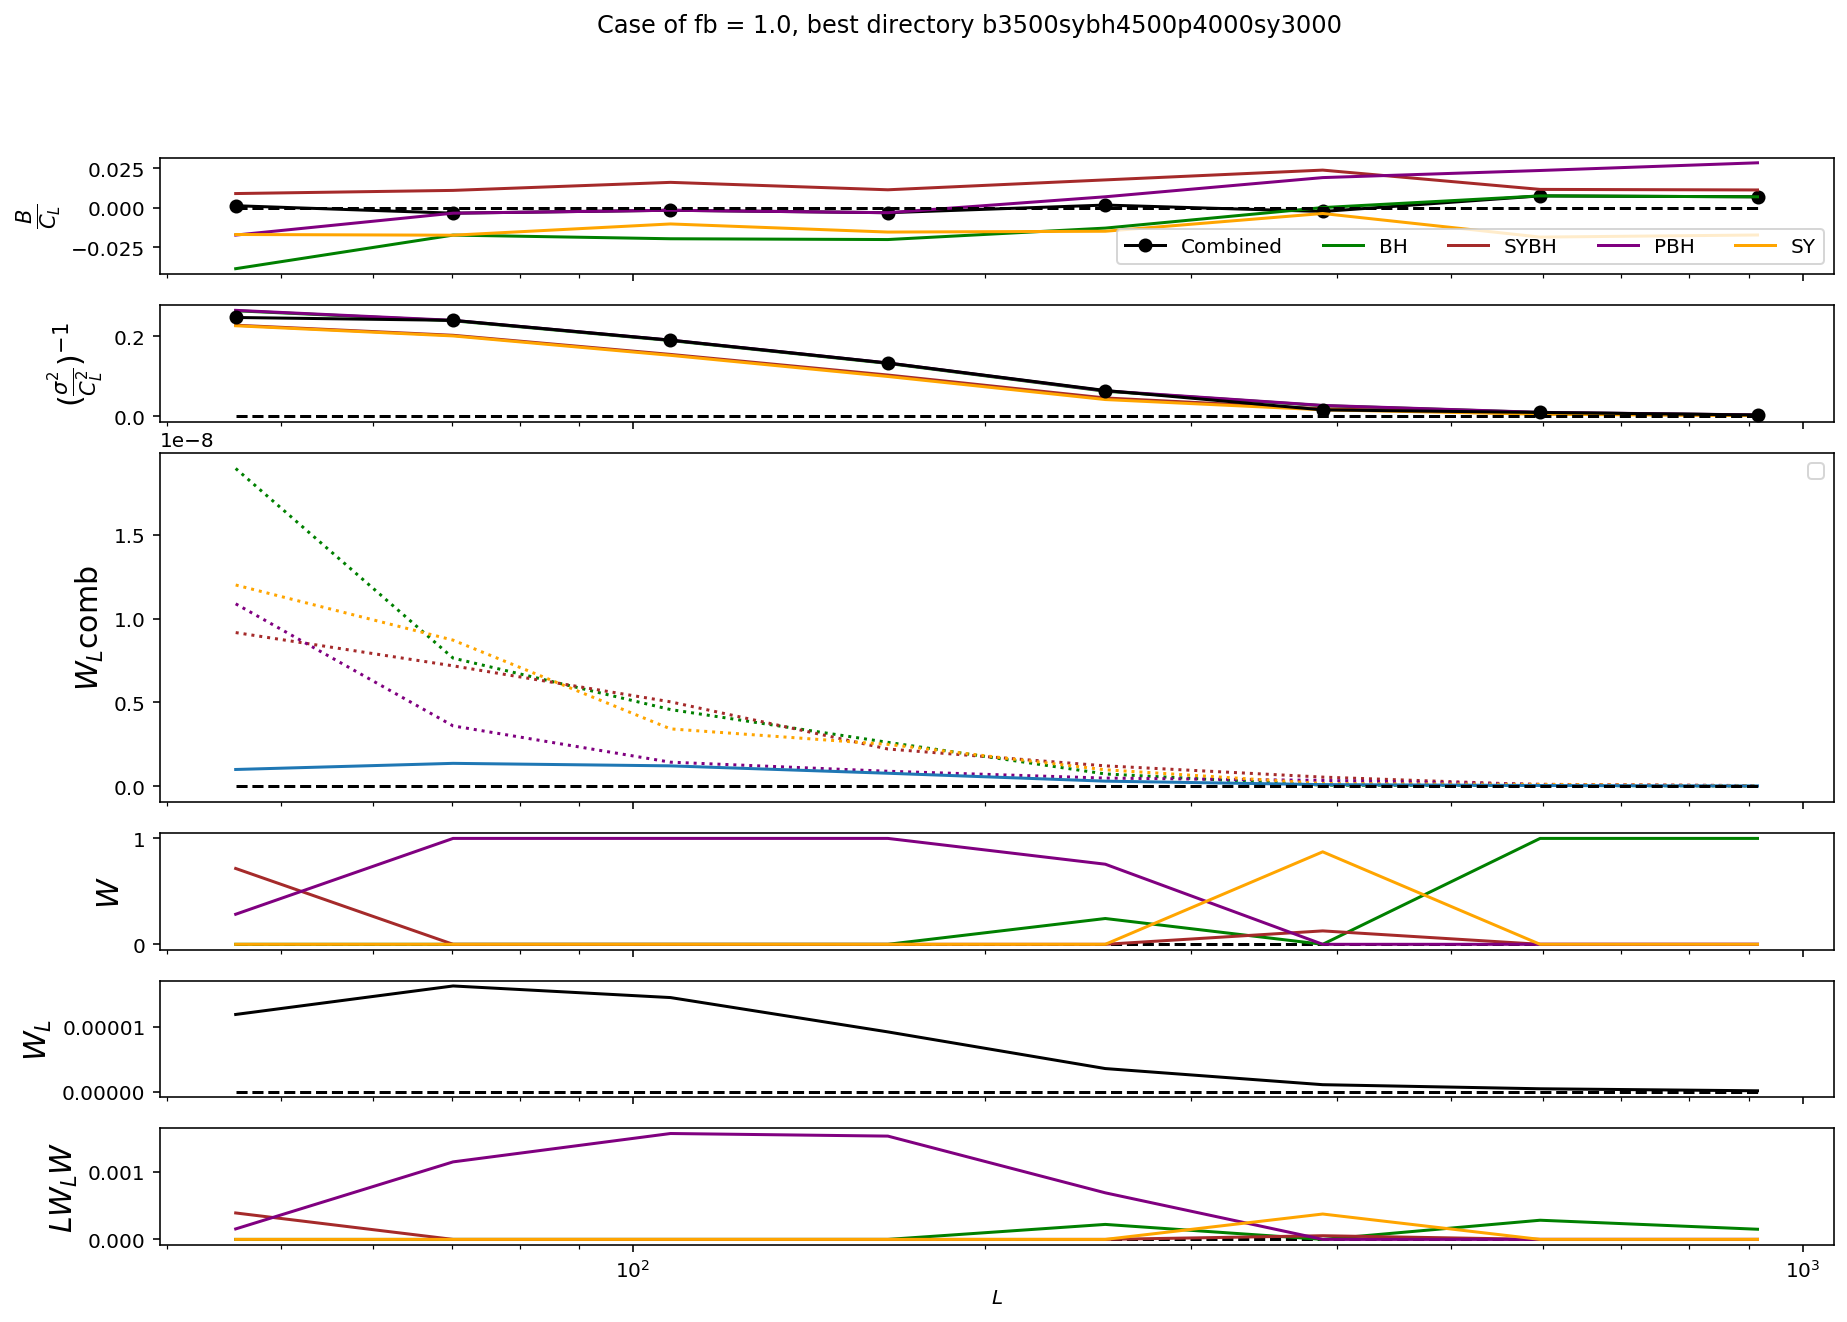

In [132]:
do_all(direc_of_choice, all_results_dir[0])

No handles with labels found to put in legend.


From resultssumfg_ILC_2903_filtered
[False False False False False  True False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
Example is for bh
Example is for symmbh
Example is for pbh
Example is for symm
(4, 8)
[[0.37164769 0.28166405 0.31628516 0.31828808 0.21445583 0.05361194
  0.12588505 0.11184396]
 [0.17968147 0.26462556 0.34816755 0.26991992 0.35643586 0.4911998
  0.23433718 0.21740687]
 [0.21331987 0.13253871 0.09904335 0.10831985 0.14164562 0.3123948
  0.32321371 0.37452266]
 [0.23535098 0.32117167 0.23650395 0.30347215 0.2874627  0.14279346
  0.31656406 0.2962265 ]]
[[0.15650189 0.19737407 0.15529964 0.16216851 0.25895142 0.6037875
  0.43023037 0.45648793]
 [0.32370375 0.21008242 0.14107854 0.19122821 0.15580262 0.06590031
  0.23111814 0.23483812]
 [0.27265893 0.41944861 0.49593408 0.47651749 0.39206042 0.10361959
  0.16756583 0.13632131]
 [0.24713543 0.1730949  0.207

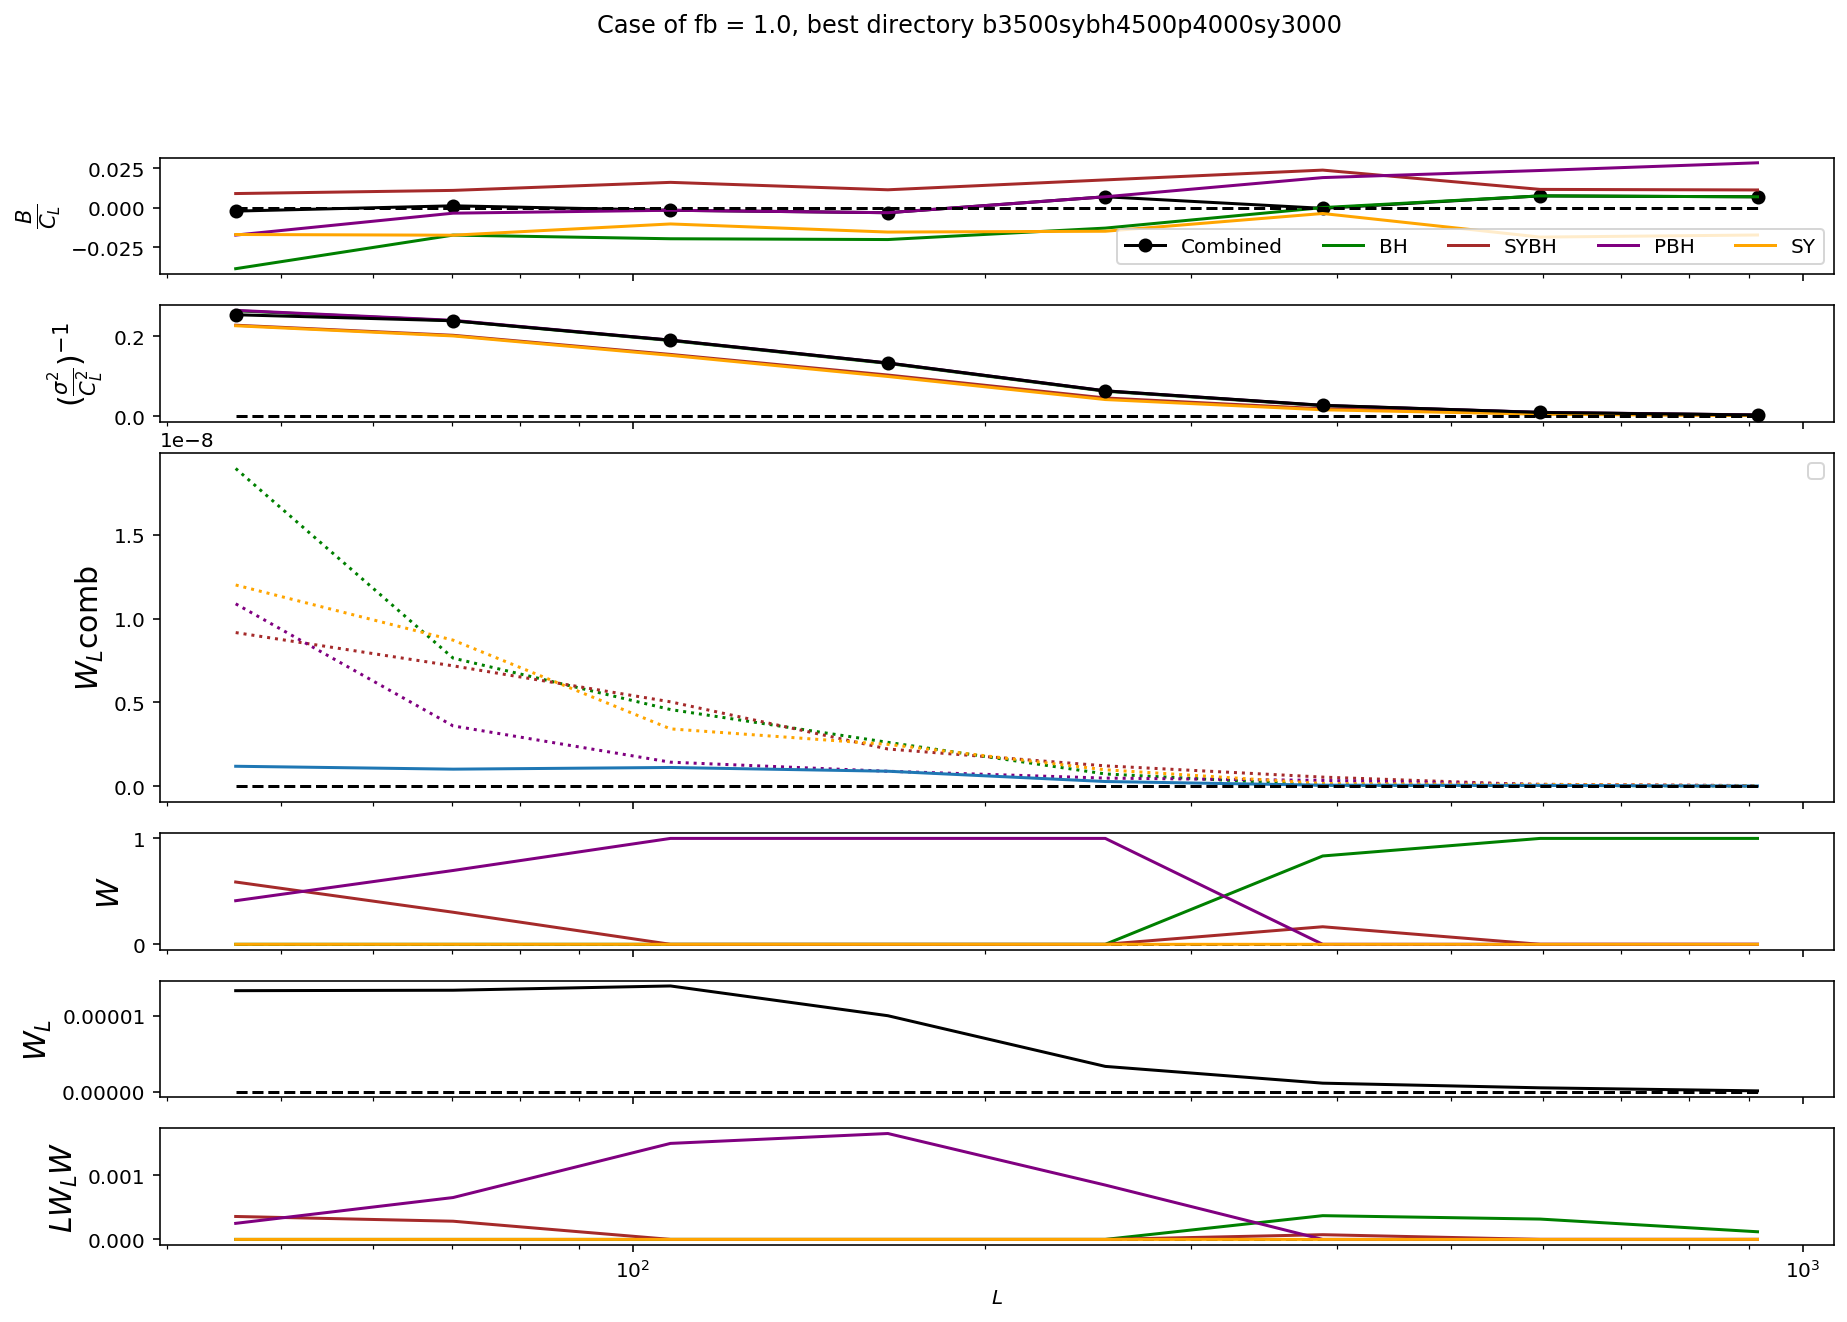

In [133]:
do_all(direc_of_choice, all_results_dir[1])

No handles with labels found to put in legend.


From resultssumfg_ILC_2903_uncertaintybiases
[False False False False False  True False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
Example is for bh
Example is for symmbh
Example is for pbh
Example is for symm
(4, 8)
[[0.37164769 0.28166405 0.31628516 0.31828808 0.21445583 0.05361194
  0.12588505 0.11184396]
 [0.17968147 0.26462556 0.34816755 0.26991992 0.35643586 0.4911998
  0.23433718 0.21740687]
 [0.21331987 0.13253871 0.09904335 0.10831985 0.14164562 0.3123948
  0.32321371 0.37452266]
 [0.23535098 0.32117167 0.23650395 0.30347215 0.2874627  0.14279346
  0.31656406 0.2962265 ]]
[[0.15650189 0.19737407 0.15529964 0.16216851 0.25895142 0.6037875
  0.43023037 0.45648793]
 [0.32370375 0.21008242 0.14107854 0.19122821 0.15580262 0.06590031
  0.23111814 0.23483812]
 [0.27265893 0.41944861 0.49593408 0.47651749 0.39206042 0.10361959
  0.16756583 0.13632131]
 [0.24713543 0.17309

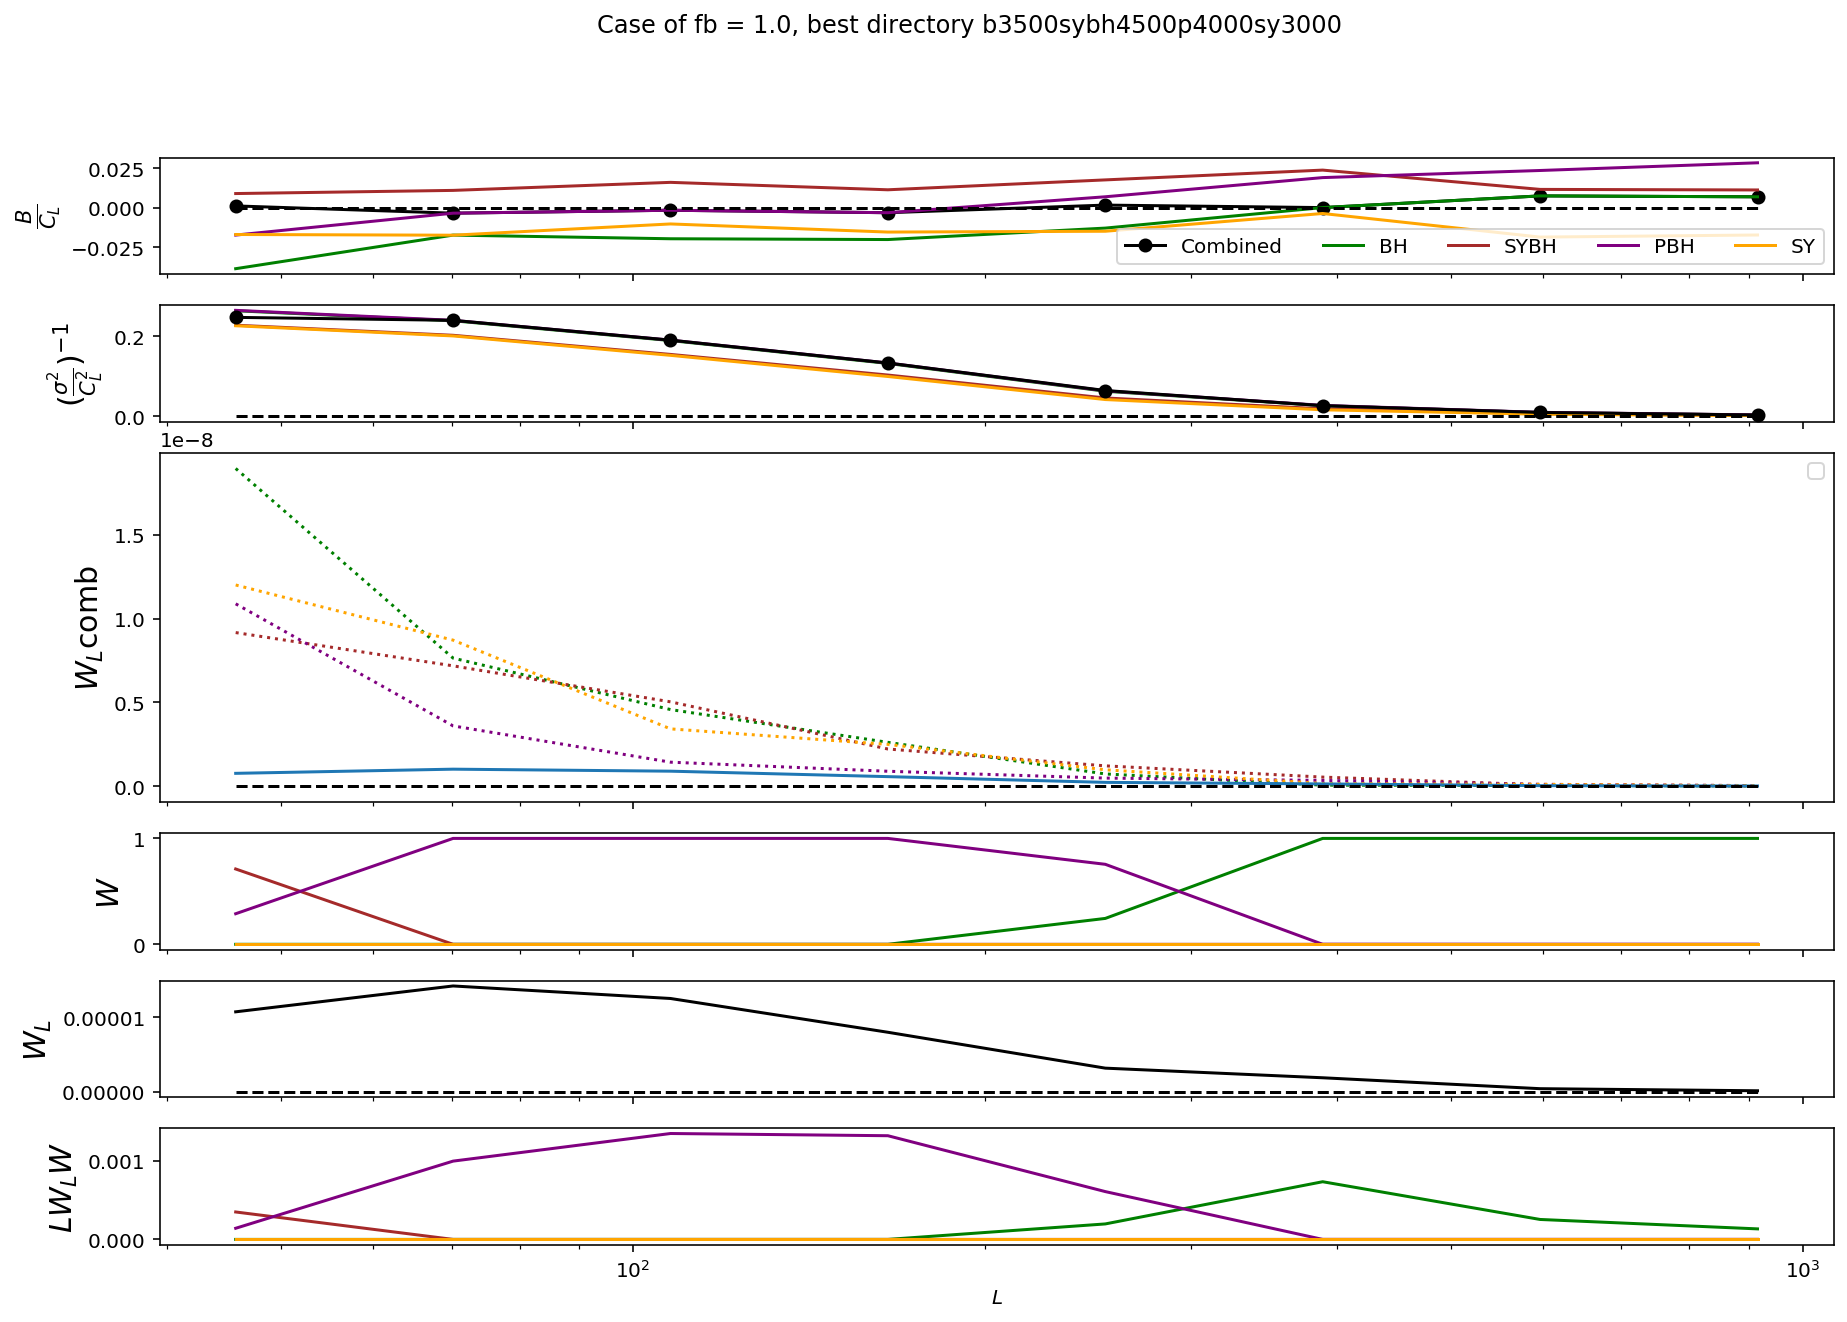

In [134]:
do_all(direc_of_choice, all_results_dir[2])

In [272]:
arr = np.linspace(1, 10)
(arr<4)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [299]:
def do_all_pre_process(directory):
    kk, theta, ells, biases, noises, w, x = get_info(directory)

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    
    Nestimators = len(Optimizerkk.estimators)
    Ne = Nestimators
    results_array = np.zeros((3, Nestimators+1))
    for index in range(Nestimators):
        x_estimator = get_est_weights(Optimizerkk, index = index)
        a_estimate = Optimizerkk.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)
        results_array[:, index+1] = np.array([f_estimator, n_estimator, b_estimator])

    a = np.c_[w[1:5]].T
    wl = w[-1]
    combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
    combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)

    combinedtheta = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)

    Optimizerkk_abs = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    
    
    f, n, b = fnb_getter(Optimizerkk, fb, invvariance)
    fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)
    print('Combined precise', fcomb_abs, ncomb_abs, bcomb_abs)

    combinedb_abs = Optimizerkk_abs.get_bias_part(a, Optimizerkk_abs.biases_selected)
    combinedb_abs = combinedb_abs*bcomb_abs/Optimizerkk_abs.theory_selected


    ells = Optimizerkk.ells_selected
    kk = Optimizerkk.theory_selected
    Ne = len(Optimizerkk.estimators)


    names = ['BH', 'SYBH', 'PBH', 'SY']
    colors = ['green', 'brown', 'purple', 'orange']

    fig, ax = plt.subplots(nrows = 4, sharex = True, figsize = (15, 10))
    
    listatemp = []
    listatemp2 = []
    for index in range(Ne):
        x_estimator = get_est_weights(Optimizerkk_abs, index = index)
        a_estimate = Optimizerkk_abs.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk_abs, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)

        combinedn_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.noises_selected)
        combinedb_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.biases_selected)
        b_example = b_estimator

        combinedb_abs_example = combinedb_example*b_example/Optimizerkk_abs.theory_selected

        #variance = True
        theta_example = Optimizerkk_abs.theta_selected[index, index, index, index]
        variance = theta_example
        wl_example = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, variance)

        print(f'Example is for {Optimizerkk.estimators[index]}')

        #ax[2].plot(ells, wl_example**2*(theta_example/kk**2), color = colors[index], ls = ':')
        #ax[2].plot(ells, wl_example*combinedb_abs_example, color = colors[index], ls = '-.')
        ax[0].plot(ells, wl_example**2*(theta_example/kk**2)+wl_example*combinedb_abs_example, color = colors[index], ls = ':')
        listatemp += [wl_example**2*(theta_example/kk**2)+wl_example*combinedb_abs_example]
        
        qty = wl_example**2*(theta_example/kk**2)+wl_example**2*(combinedb_example/Optimizerkk_abs.theory_selected)**2.
        listatemp2 += [qty]
        
        #print(combinedb_example[0])
        #ax[0].plot(ells, qty, color = colors[index], marker = 'o')
        
    #print(np.array(listatemp).shape)
    inv = np.array(listatemp)**-1.
    #print(np.array(listatemp)/np.sum(np.array(listatemp), axis = 0))
    #print(inv/np.sum(np.array(inv), axis = 0))
    
    ax[0].plot(ells, wl**2*(combinedtheta/kk**2)+wl*combinedb_abs)
        
    ax[0].plot(ells, ells*0, color = 'black', ls = '--')
    ax[0].legend(loc = 'best', ncol = 2)

    ax[1].plot(ells, ells*0, color = 'black', ls = '--')
    ax[2].plot(ells, ells*0, color = 'black', ls = '--')
    ax[3].plot(ells, ells*0, color = 'black', ls = '--')
    
    weights_ = inv/np.sum(np.array(inv))
    #print(weights_)
    
    listatemp = np.array(listatemp)
    listatemp2 = np.array(listatemp2)
    
    weights_new = listatemp**-2/np.sum(listatemp**-2, axis = 0)
    a = weights_new.T
    cc = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)
    ww = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, cc)
    xx = np.append(a.flatten(), ww)
    f, n, b = fnb_getter(Optimizerkk, fb, invvariance)
    print('Combined naive', f(xx), n(xx), b(xx))
    
    weights_new2 = listatemp2**-2/np.sum(listatemp2**-2, axis = 0)
    
    for i in range(Ne):
        ax[1].plot(ells, w[1+i], color = colors[i])
        ax[1].plot(ells, weights_new[i], color = colors[i], ls = '--')
        #ax[1].plot(ells, weights_new2[i], color = colors[i], ls = ':')
        ax[3].plot(ells, w[1+i]*wl*ells, color = colors[i])
        
    ax[1].plot(ells, w[1]*0.+0.1, color = 'cyan')

    ax[2].plot(ells, wl, color = 'black')
    
    ax[0].set_ylabel('$W_L\\mathrm{comb}$', size = 15)
    ax[1].set_ylabel('$W$', size = 15)
    ax[2].set_ylabel('$W_L$', size = 15)
    ax[3].set_ylabel('$LW_LW$', size = 15)

    ax[0].set_xscale('log')
    ax[-1].set_xlabel('$L$')
    
    ax[0].set_ylim(1e-11, 5e-9)
    
    return listatemp

In [300]:
directory

'b4500sybh4500p3500sy3500'

In [301]:
lista = np.array(lista)

In [302]:
weights_new = lista**-2/np.sum(lista**-2, axis = 0)

In [303]:
weights_new.sum(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [304]:
weights_new

array([[8.27336137e-03, 9.37182975e-03, 6.95974304e-03, 1.20273655e-02,
        1.58602773e-01, 9.84261267e-03, 1.23805455e-03, 4.19611060e-04],
       [3.23099005e-01, 8.43347133e-02, 5.00862722e-02, 1.12831757e-01,
        3.31371329e-02, 4.29494833e-02, 1.10336497e-01, 1.06386757e-01],
       [6.27144349e-01, 8.91586997e-01, 9.17238206e-01, 8.50547736e-01,
        7.91276990e-01, 8.56222757e-01, 8.44312032e-01, 8.63762813e-01],
       [4.14832853e-02, 1.47064597e-02, 2.57157787e-02, 2.45931416e-02,
        1.69831040e-02, 9.09851468e-02, 4.41134168e-02, 2.94308189e-02]])

No handles with labels found to put in legend.


Combined precise 5.874741633788319e-05 0.007645938960092674 -0.0005357553139448447
Example is for bh
Example is for symmbh
Example is for pbh
Example is for symm
Combined naive 6.348138317390943e-05 0.007778103896339678 -0.0017269866680594142


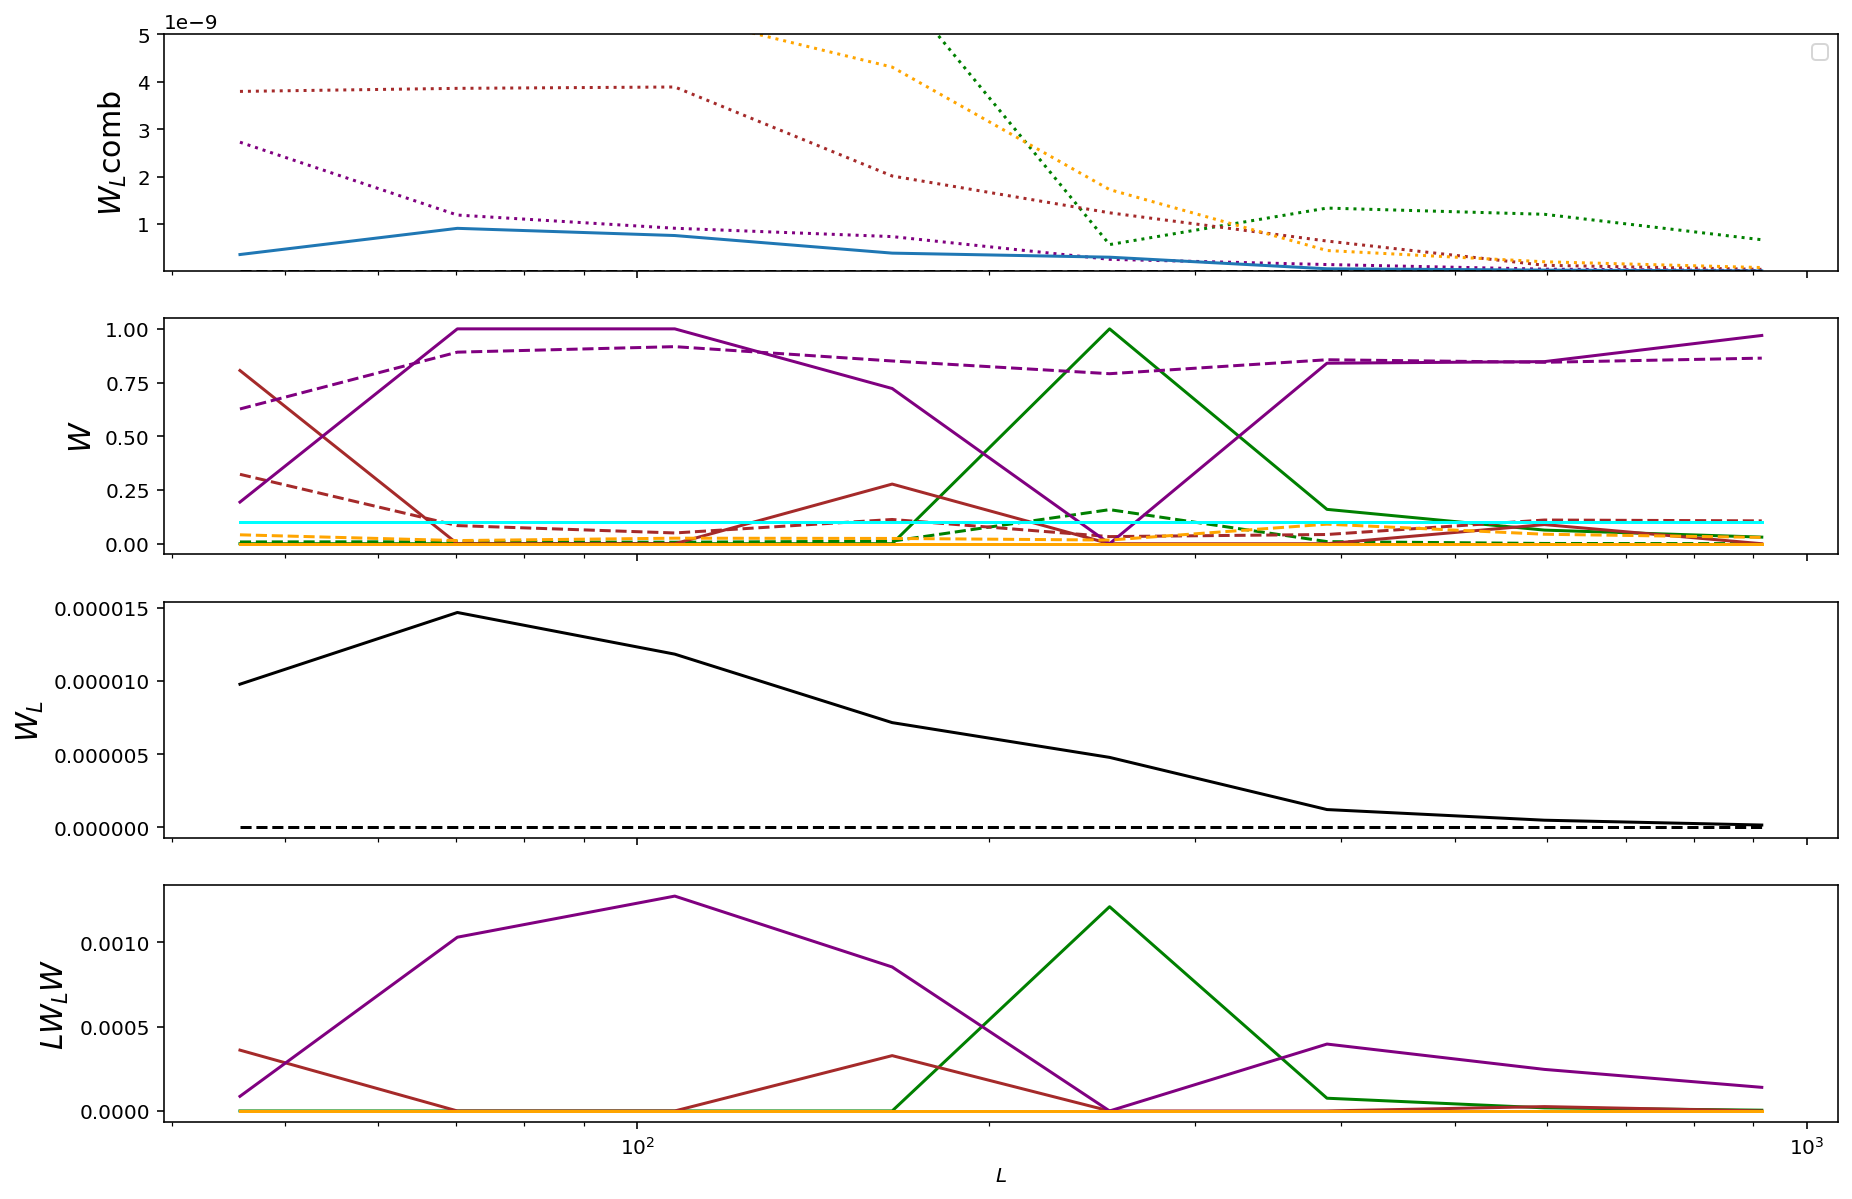

In [305]:
lista = do_all_pre_process(directory)

In [311]:
def do_all_pre_process_naive(directory):
    kk, theta, ells, biases, noises, w, x = get_info(directory)

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    
    Nestimators = len(Optimizerkk.estimators)
    Ne = Nestimators
    results_array = np.zeros((3, Nestimators+1))
    for index in range(Nestimators):
        x_estimator = get_est_weights(Optimizerkk, index = index)
        a_estimate = Optimizerkk.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)
        results_array[:, index+1] = np.array([f_estimator, n_estimator, b_estimator])

    a = np.c_[w[1:5]].T
    wl = w[-1]
    combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
    combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)

    combinedtheta = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)

    Optimizerkk_abs = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    
    
    f, n, b = fnb_getter(Optimizerkk, fb, invvariance)
    fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)
    #print('Combined precise', fcomb_abs, ncomb_abs, bcomb_abs)

    combinedb_abs = Optimizerkk_abs.get_bias_part(a, Optimizerkk_abs.biases_selected)
    combinedb_abs = combinedb_abs*bcomb_abs/Optimizerkk_abs.theory_selected


    ells = Optimizerkk.ells_selected
    kk = Optimizerkk.theory_selected
    Ne = len(Optimizerkk.estimators)


    names = ['BH', 'SYBH', 'PBH', 'SY']
    colors = ['green', 'brown', 'purple', 'orange']
    
    listatemp = []
    listatemp2 = []
    for index in range(Ne):
        x_estimator = get_est_weights(Optimizerkk_abs, index = index)
        a_estimate = Optimizerkk_abs.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk_abs, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)

        combinedn_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.noises_selected)
        combinedb_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.biases_selected)
        b_example = b_estimator

        combinedb_abs_example = combinedb_example*b_example/Optimizerkk_abs.theory_selected

        #variance = True
        theta_example = Optimizerkk_abs.theta_selected[index, index, index, index]
        variance = theta_example
        wl_example = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, variance)

        #print(f'Example is for {Optimizerkk.estimators[index]}')

        #ax[2].plot(ells, wl_example**2*(theta_example/kk**2), color = colors[index], ls = ':')
        #ax[2].plot(ells, wl_example*combinedb_abs_example, color = colors[index], ls = '-.')
        listatemp += [wl_example**2*(theta_example/kk**2)+wl_example*combinedb_abs_example]
        
        qty = wl_example**2*(theta_example/kk**2)+wl_example**2*(combinedb_example/Optimizerkk_abs.theory_selected)**2.
        listatemp2 += [qty]
        
        #print(combinedb_example[0])
        #ax[0].plot(ells, qty, color = colors[index], marker = 'o')
        
    #print(np.array(listatemp).shape)
    inv = np.array(listatemp)**-1.

    listatemp = np.array(listatemp)
    listatemp2 = np.array(listatemp2)
    
    weights_new = listatemp**-2/np.sum(listatemp**-2, axis = 0)
    a = weights_new.T
    cc = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)
    ww = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, cc)
    xx = np.append(a.flatten(), ww)
    f, n, b = fnb_getter(Optimizerkk, fb, invvariance)
    #print('Combined naive', f(xx), n(xx), b(xx))
    
    weights_new2 = listatemp2**-2/np.sum(listatemp2**-2, axis = 0)
    
    return fcomb_abs, ncomb_abs, bcomb_abs, f(xx), n(xx), b(xx)

In [330]:
direcs = []
for numdir, directory in enumerate(all_lmaxes_directories):
    try:
        fcomb_abs, ncomb_abs, bcomb_abs, f, n, b = do_all_pre_process_naive(directory)
        if np.nan_to_num(fcomb_abs) == 0.:
            print('DR', directory)
        else:
            direcs += [directory]
    except:
        print(directory)

b3000sybh4500p3500sy4000
b3500sybh4500p3000sy3500
b4500sybh3500p3000sy4500
b3000sybh4000p3500sy3000
b3000sybh3000p3500sy3000
b3500sybh3500p3500sy4500
DR b4000sybh3500p3000sy3000
b3500sybh4000p3000sy4000
b3000sybh4000p4000sy3000


In [383]:
all_fs = np.zeros((3, len(direcs)))
all_fs_naive = np.zeros((3, len(direcs)))


for numdir, directory in enumerate(direcs):
    try:
        fcomb_abs, ncomb_abs, bcomb_abs, f, n, b = do_all_pre_process_naive(directory)
        
        all_fs[:, numdir] = np.array([fcomb_abs, ncomb_abs, bcomb_abs])
        all_fs_naive[:, numdir] = np.array([f, n, b])
    except:
        print(directory)

all_fs_lista = list(all_fs[0, :])
all_fs_naive_lista = list(all_fs_naive[0, :])

minimo = np.min(all_fs[0, :])
indmin = all_fs_lista.index(minimo)

minimo = np.min(all_fs_naive[0, :])
indmin_naive = all_fs_naive_lista.index(minimo)

directorymin = direcs[indmin]
print('MIN', directorymin, all_fs[0, :][indmin])

directorymin = direcs[indmin_naive]
print('MIN Naive', directorymin, all_fs_naive[0, :][indmin_naive])

MIN b4500sybh4500p3500sy3500 5.874741633788319e-05
MIN Naive b4000sybh4500p4000sy4000 5.941941798922232e-05


In [384]:
p = {}
p['Direcs'] = direcs
p['f'] = all_fs[0, :]
p['n'] = all_fs[1, :]
p['b'] = all_fs[2, :]
p['f naive'] = all_fs_naive[0, :]
p['n naive'] = all_fs_naive[1, :]
p['b naive'] = all_fs_naive[2, :]
pp = pandas.DataFrame(p)
pandas.set_option("display.precision", 8)

In [385]:
pp['Check'] = (pp['f']>pp['f naive'])

In [387]:
pp.sort_values('f').head(30)

,Direcs,f,n,b,f naive,n naive,b naive,Check
70,b4500sybh4500p3500sy3500,0.00005875,0.00764594,-0.00053576,0.00006348,0.00777810,-0.00172699,False
192,b3500sybh4000p4000sy3500,0.00005944,0.00767144,0.00077062,0.00006085,0.00761643,-0.00168475,False
212,b3500sybh4000p4000sy4500,0.00005947,0.00770744,0.00025045,0.00006123,0.00760911,-0.00182593,False
215,b3500sybh3500p4000sy4000,0.00005963,0.00768889,0.00071489,0.00006243,0.00778087,-0.00137296,False
84,b3500sybh3500p4000sy4500,0.00005972,0.00772542,0.00018209,0.00006326,0.00777691,-0.00166839,False
199,b4000sybh4000p3500sy3500,0.00005980,0.00771117,-0.00058230,0.00006073,0.00779233,0.00008483,False
17,b3500sybh4000p4000sy4000,0.00006005,0.00772914,0.00055880,0.00006066,0.00760980,-0.00165779,False
40,b3500sybh4500p4000sy4000,0.00006036,0.00775375,0.00049236,0.00006420,0.00744837,-0.00295280,False
241,b3500sybh4500p4000sy3500,0.00006037,0.00775415,0.00049215,0.00006329,0.00745457,-0.00277849,False
183,b4000sybh4500p3500sy4000,0.00006079,0.00779284,0.00025417,0.00006304,0.00779198,-0.00152512,False


In [390]:
set(pp.sort_values('f').head(30)['Direcs'])

{'b3500sybh3500p3500sy4000',
 'b3500sybh3500p4000sy4000',
 'b3500sybh3500p4000sy4500',
 'b3500sybh3500p4500sy3000',
 'b3500sybh3500p4500sy3500',
 'b3500sybh3500p4500sy4000',
 'b3500sybh4000p3500sy3500',
 'b3500sybh4000p3500sy4000',
 'b3500sybh4000p3500sy4500',
 'b3500sybh4000p4000sy3500',
 'b3500sybh4000p4000sy4000',
 'b3500sybh4000p4000sy4500',
 'b3500sybh4500p3500sy3500',
 'b3500sybh4500p3500sy4500',
 'b3500sybh4500p4000sy3500',
 'b3500sybh4500p4000sy4000',
 'b3500sybh4500p4500sy4500',
 'b4000sybh3000p3500sy3500',
 'b4000sybh3000p3500sy4000',
 'b4000sybh3500p3500sy3000',
 'b4000sybh3500p3500sy3500',
 'b4000sybh3500p3500sy4000',
 'b4000sybh4000p3500sy3000',
 'b4000sybh4000p3500sy3500',
 'b4000sybh4000p3500sy4500',
 'b4000sybh4500p3500sy3500',
 'b4000sybh4500p3500sy4000',
 'b4000sybh4500p3500sy4500',
 'b4500sybh4500p3500sy3500',
 'b4500sybh4500p3500sy4000'}

In [388]:
pp.sort_values('f naive').head(30)

,Direcs,f,n,b,f naive,n naive,b naive,Check
6,b4000sybh4500p4000sy4000,0.00006812,0.00819615,-0.00096951,0.00005942,0.00752568,-0.00166840,True
98,b4500sybh4500p4000sy4000,0.00007333,0.00831435,-0.00204933,0.00005958,0.00754519,-0.00162663,True
159,b4000sybh4500p4000sy3500,0.00007091,0.00833358,-0.00120885,0.00006003,0.00756757,-0.00166076,True
20,b4500sybh4500p4000sy3500,0.00007017,0.00818032,-0.00180457,0.00006028,0.00759760,-0.00159969,True
234,b4500sybh4000p3500sy3500,0.00006725,0.00806325,-0.00149324,0.00006060,0.00778287,-0.00015420,True
185,b4500sybh4000p3500sy4000,0.00006282,0.00791886,0.00033013,0.00006060,0.00778386,-0.00010488,True
165,b4500sybh4000p3500sy4500,0.00006755,0.00801656,-0.00181101,0.00006066,0.00778427,-0.00024829,True
17,b3500sybh4000p4000sy4000,0.00006005,0.00772914,0.00055880,0.00006066,0.00760980,-0.00165779,False
199,b4000sybh4000p3500sy3500,0.00005980,0.00771117,-0.00058230,0.00006073,0.00779233,0.00008483,False
68,b4000sybh4000p3500sy4500,0.00006107,0.00779890,0.00049328,0.00006073,0.00779322,-0.00000961,True


In [361]:
print(pp.sort_values('f')['Direcs'])
print(pp.sort_values('f naive')['Direcs'])

70     b4500sybh4500p3500sy3500
192    b3500sybh4000p4000sy3500
212    b3500sybh4000p4000sy4500
215    b3500sybh3500p4000sy4000
84     b3500sybh3500p4000sy4500
                 ...           
96     b3000sybh4500p3000sy4500
181    b4000sybh3000p3500sy4500
201    b4500sybh3000p3000sy4500
73     b4000sybh3000p3000sy3500
87     b4500sybh3000p3000sy4000
Name: Direcs, Length: 247, dtype: object
6      b4000sybh4500p4000sy4000
98     b4500sybh4500p4000sy4000
159    b4000sybh4500p4000sy3500
20     b4500sybh4500p4000sy3500
234    b4500sybh4000p3500sy3500
                 ...           
39     b4500sybh4500p3000sy3000
123    b3500sybh4500p3000sy3000
243    b4500sybh4500p3000sy4500
166    b3000sybh4500p3000sy3000
96     b3000sybh4500p3000sy4500
Name: Direcs, Length: 247, dtype: object
